In [2]:
import torch
import gpytorch
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('..'))

from src.plotting import plot_gp, plot_train_test_split
from src.data_loader import PVDataGenerator
from src import data_loader as dl


In [3]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

num_latent = 5

==> Loading data
==> Loaded data in: 0 m : 14 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



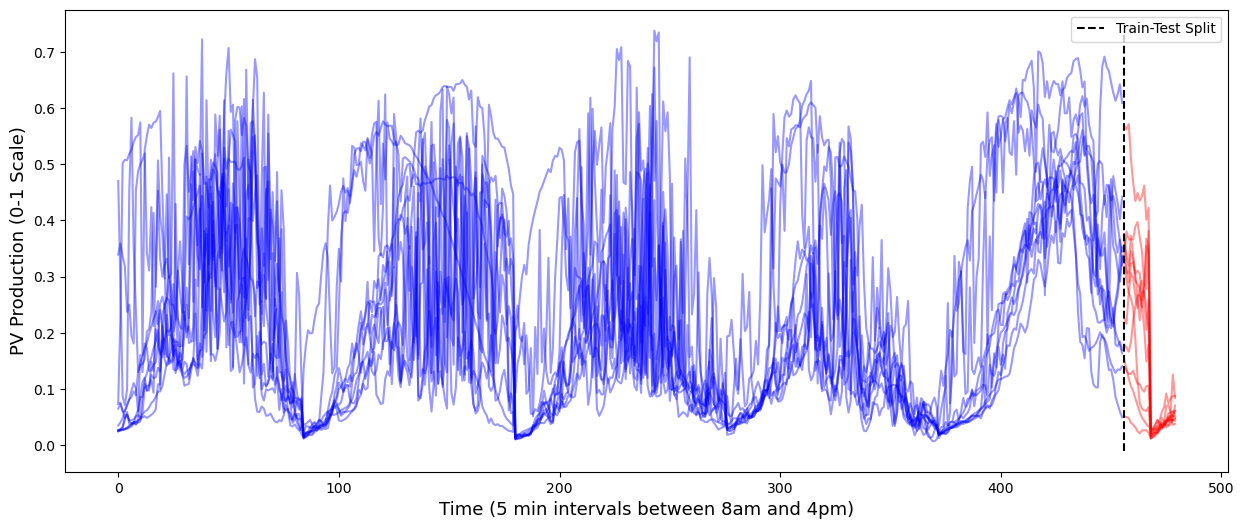

In [4]:
loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = loader.get_time_series()

# scale time at 0 dim to [0, 1]
X[:, 0] = X[:,0] / X[:, 0].max()

x_train, y_train, x_test, y_test = dl.train_test_split(X, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [6]:
from src.models import MultitaskGPModel
from src.kernel import generate_quasi_periodic

In [7]:
model = MultitaskGPModel(x_train=x_train,
                         y_train=y_train,
                         likelihood=gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y_train.size(-1)),
                         mean_module=gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latent])),
                         covar_module=generate_quasi_periodic(num_latents=num_latent),
                         num_latents=num_latent,
                         jitter=1e-3)

In [8]:
model.fit(n_iter=300, lr=0.1, verbose=True)

Iter 30/300 - Loss: 13.313592910766602
Iter 60/300 - Loss: 2.8485257625579834
Iter 90/300 - Loss: -6.066873550415039
Iter 120/300 - Loss: -8.699509620666504
Iter 150/300 - Loss: -9.448487281799316


KeyboardInterrupt: 

torch.Size([456, 2]) torch.Size([24, 2])
torch.Size([456, 11]) torch.Size([24, 11])


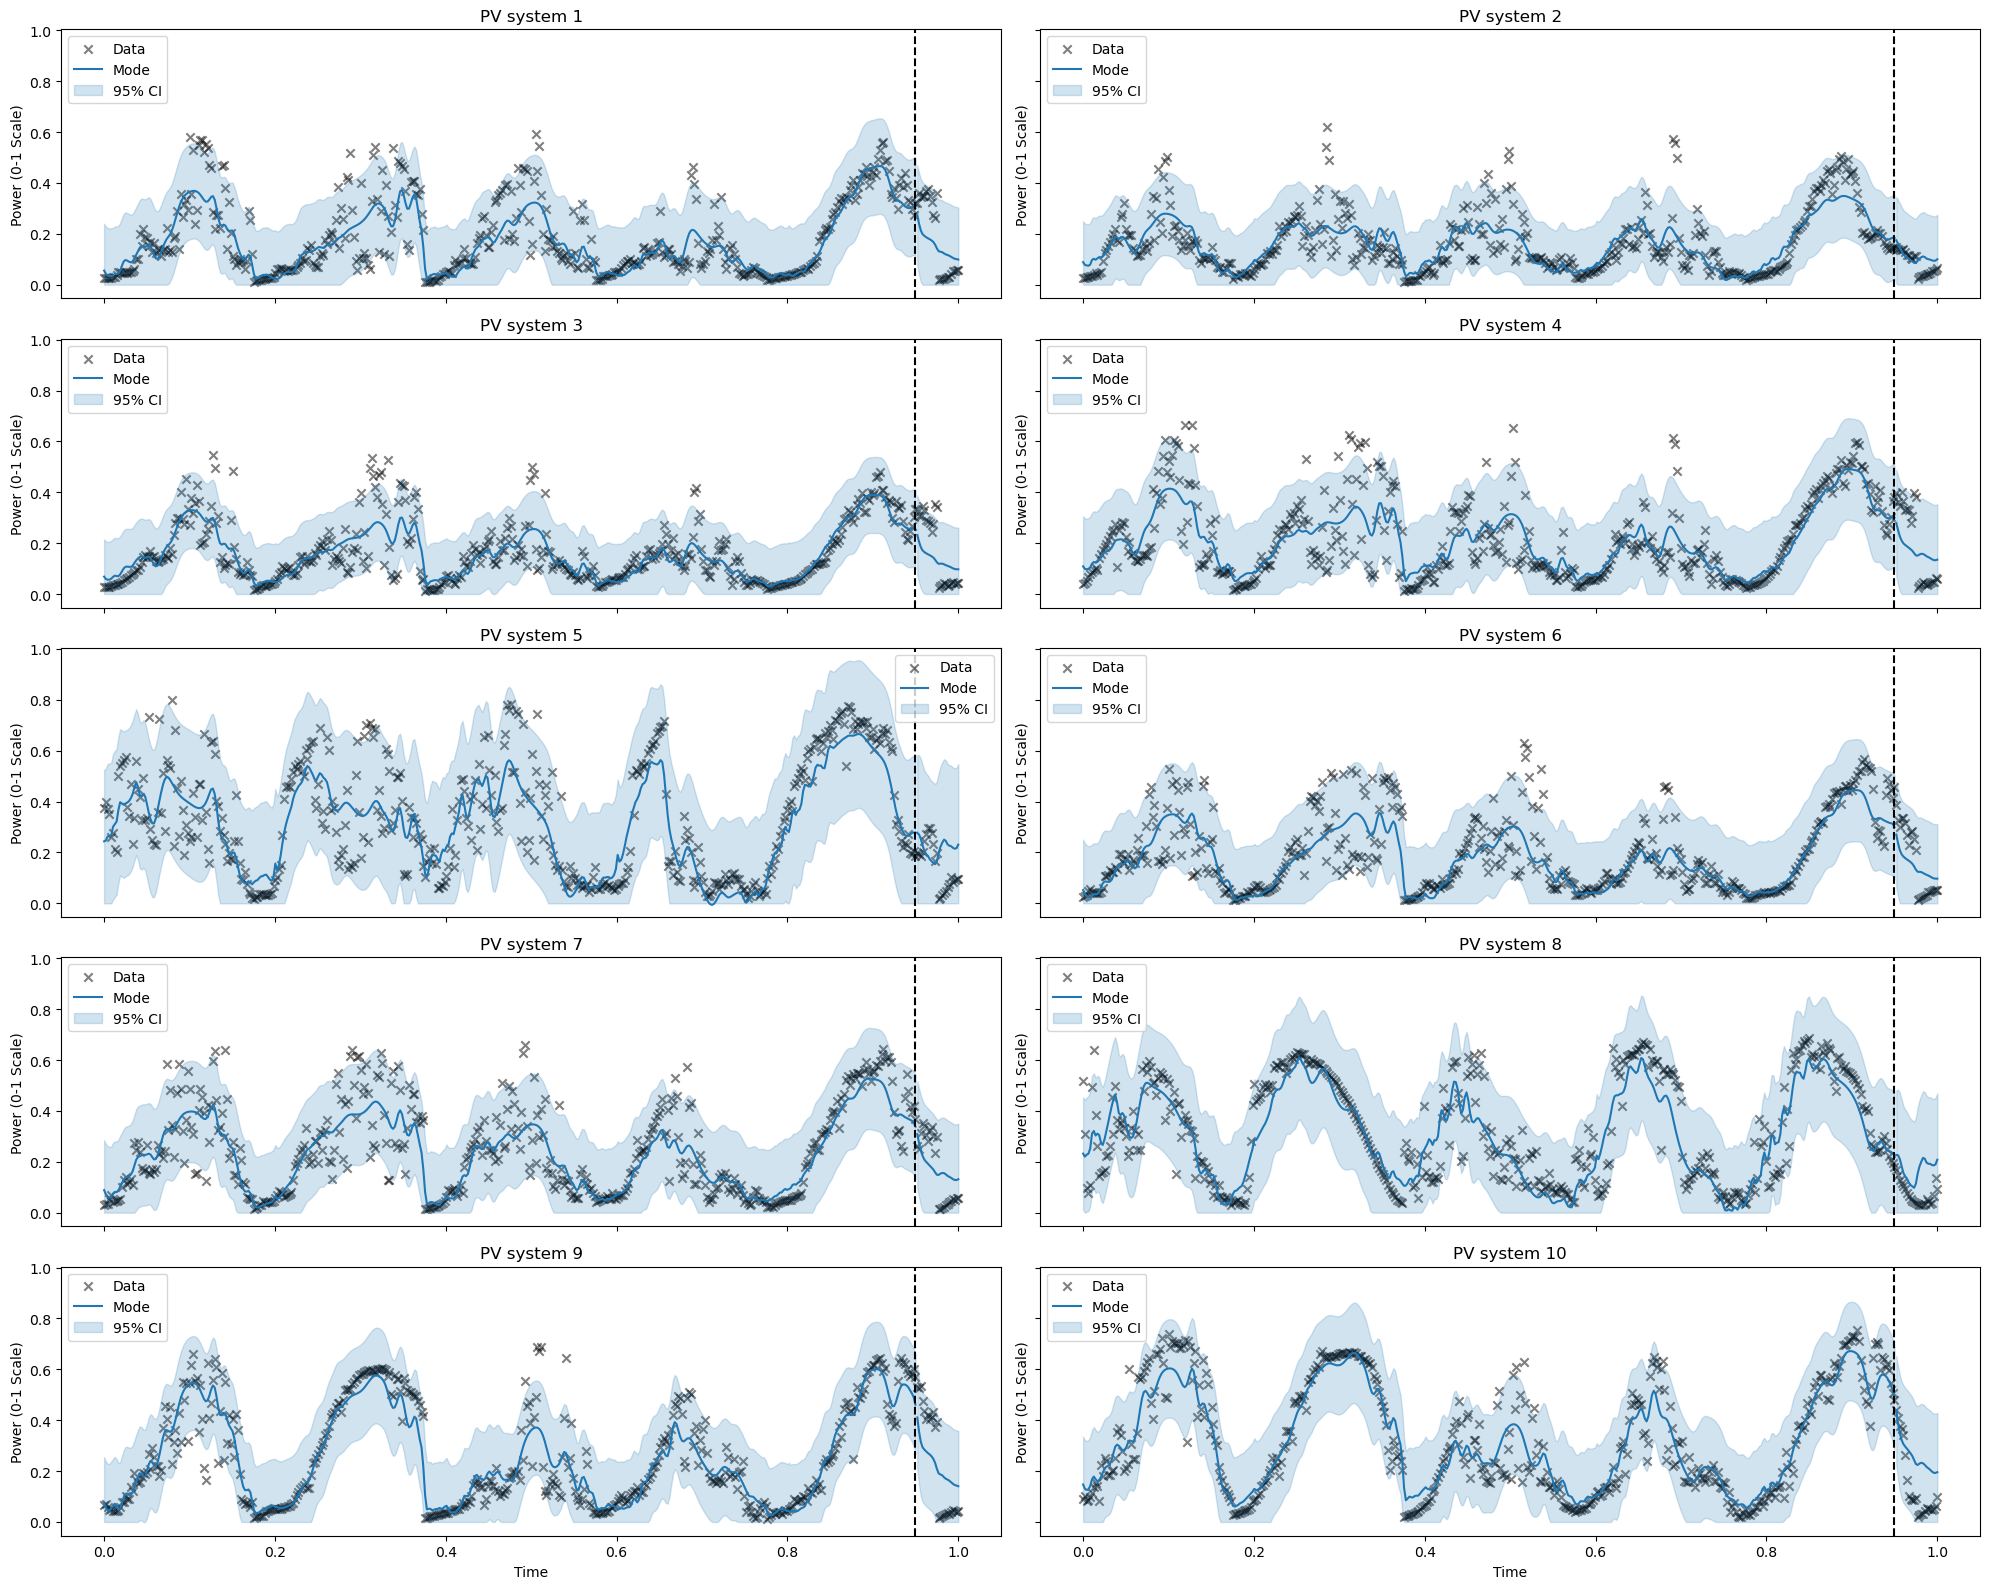

In [10]:
from matplotlib import pyplot as plt

preds_tr, lower_tr, upper_tr = model.predict(model.likelihood, x_train)
preds_te, lower_te, upper_te = model.predict(model.likelihood, x_test)

lower_tr = torch.clamp(lower_tr, min=0, max=1)
upper_tr = torch.clamp(upper_tr, min=0, max=1)
lower_te = torch.clamp(lower_te, min=0, max=1)
upper_te = torch.clamp(upper_te, min=0, max=1)


t_train = x_train[:, 0].detach().cpu().numpy()
t_test = x_test[:, 0].detach().cpu().numpy()

n_rows = 5
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 16), sharex=True, sharey=True)

ax = ax.flatten()

for i in range(y_train.size(-1) - 1):
    ax[i].scatter(t_train, y_train[:, i].detach().cpu().numpy(),marker='x', color='k', alpha=0.5)
    ax[i].scatter(t_test, y_test[:, i].detach().cpu().numpy(),marker='x', color='k', alpha=0.5, label='Data')

    ax[i].plot(t_train, preds_tr[:, i].detach().cpu().numpy(), color='C0', label='Mode')
    ax[i].plot(t_test, preds_te[:, i].detach().cpu().numpy(), color='C0')

    ax[i].fill_between(t_train, lower_tr[:, i], upper_tr[:, i], color='C0', alpha=0.2)
    ax[i].fill_between(t_test, lower_te[:, i], upper_te[:, i], color='C0', alpha=0.2, label='95% CI')

    ax[i].axvline(t_train[-1], color='k', linestyle='--')

    if i+1 % 2 != 0:
        ax[i].set_ylabel('Power (0-1 Scale)')

    if i+1 > n_rows * n_cols - n_cols:
        ax[i].set_xlabel('Time')
    
    ax[i].set_title(f'PV system {i+1}')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [9]:
from src.beta_likelihood import MultitaskBetaLikelihood

In [ ]:
model = MultitaskGPModel(x_train=x_train,
                         y_train=y_train,
                         likelihood=MultitaskBetaLikelihood(num_tasks=y_train.size(-1)),
                                                            batch_shape=torch.Size([num_latent])),
                         mean_module=gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latent])),
                         covar_module=generate_quasi_periodic(num_latents=num_latent),
                         num_latents=num_latent,